In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from common import *
from math import *

In [116]:
itempath = "data-2d-periodical-x0var/57"
target_2D = True
reset_type = 'per'

In [117]:
ppath = itempath+"-params.csv"
df = pd.read_csv(ppath, sep=',', header=None)
params = dict(df.set_index(0).T.squeeze())
params

{'D': 1.0,
 'part_m': 0.0,
 'x0sigma': 0.05,
 'L': 0.2,
 'b': 4.0,
 'c': 2.23606797749979,
 'mfpt': 0.003317315559982605,
 'fpt_stdev': 0.0037378132745940367,
 'n_traj': 50180.0,
 'Delta_t': 1e-07,
 'Rtol': 0.15,
 'a': 0.7499999999999999,
 'reset_period': 0.002}

In [118]:
σ = params['x0sigma']
L = params['L']
D = params['D']
c = params['c']
b = L/σ
if target_2D:
    a = params['a']

if reset_type == 'none':
    th_fpt_distrib = None # TODO
    th_tau = th_tau_2d = None
elif reset_type == 'poisson':
    α = params['reset_rate']
    th_fpt_distrib = None # TODO
    if not target_2D:
        th_tau = fpt_poisson_tau
    else:
        th_tau_2d = fpt_2d_poisson_tau
elif reset_type == 'per':
    rT = params['reset_period']
    if not target_2D:
        th_fpt_distrib = lambda t, b, c: fpt_periodic_disrib(t, rT, b, c)
        th_tau = fpt_periodic_tau
    else:
        th_fpt_distrib = None # TODO
        th_tau_2d = np.vectorize(lambda b,c,a: fpt_2d_periodical_tau(b,c,a, use_cache="th-cache-2d-periodical/"))
tau_th_cache = None

In [119]:
first_times = np.loadtxt(itempath+"-ft.csv")
n_traj = len(first_times)

if not target_2D:
    mfpt_th = L**2/(4*D)*th_tau(b,c)
else:
    mfpt_th = L**2/(4*D)*th_tau_2d(b,c,a)

mfpt = np.mean(first_times)

def fpt_distrib_title ():
    plt.xlabel("first passage time")
    if reset_type == 'poisson':
        if not target_2D:
            plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$ ($D={:.3f}$, $\alpha={}$, $\sigma_{{x_0}}={:.3f}$, $L={}$)".format(b, c, D, α, σ, L))
        else:
            plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$, $a={:.2f}$ ($D={:.3f}$, $\alpha={}$, $\sigma_{{x_0}}={:.3f}$, $L={}$)".format(b, c, a, D, α, σ, L))
    elif reset_type == 'per':
        if not target_2D:
            plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$ ($D={:.3f}$, $T_\operatorname{{res}}={}$, $\sigma_{{x_0}}={:.3f}$, $L={}$)".format(b, c, D, rT, σ, L))
        else:
            plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$, $a={:.2f}$ ($D={:.3f}$, $T_\operatorname{{res}}={}$, $\sigma_{{x_0}}={:.3f}$, $L={}$)".format(b, c, a, D, rT, σ, L))
    plt.legend()

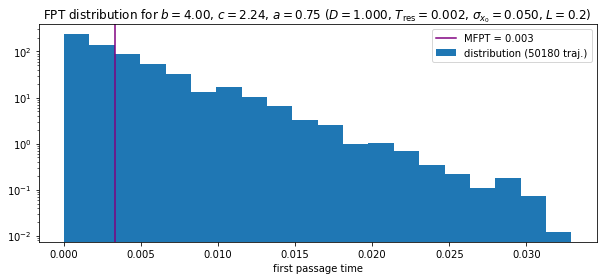

In [120]:
plt.figure(figsize=(10,4))
fpt_max = 10*mfpt_th
plt.hist(first_times, bins=20, range=(0,fpt_max), weights=20/fpt_max*np.ones(n_traj)/n_traj, label="distribution ({} traj.)".format(n_traj))
plt.axvline(x=mfpt, color='purple', label="MFPT = {:.3f}".format(mfpt))
plt.yscale('log')
fpt_distrib_title()
None

In [121]:
if reset_type == 'per' and not target_2D:
    fpt_max = 0.999*max(3, ceil(2*mfpt_th/rT))*rT
    t_th = np.linspace(0, fpt_max, 400)+3e-4
    d_th = -( fpt_periodic_survival(t_th+1e-4, rT, b, c) - fpt_periodic_survival(t_th-1e-4, rT, b, c) ) / 2e-4
elif reset_type == 'poisson' and not target_2D:
    fpt_max = 5*mfpt_th
    t_th = np.logspace(log(mfpt_th/20/b), log(fpt_max), 50, base=np.e)
    d_th = fpt_poisson_distrib(L, t_th, α, D, σ)
else:
    fpt_max = 5*mfpt_th
    t_th = None

def do_fpt_distrib (log=True, bins=200):
    global fpt_max, t_th, d_th
    plt.figure(figsize=(12,4))
    _,bins,_ = plt.hist(first_times, bins=bins, range=(0,fpt_max), weights=bins/fpt_max*np.ones(n_traj)/n_traj, label="distribution ({} traj.)".format(n_traj))
    plt.axvline(x=mfpt, color='purple', label="MFPT (mes.) = {:.3f}".format(mfpt))
    plt.axvline(x=mfpt_th, color='black', label="MFPT (th.) = {:.3f}".format(mfpt_th))
    if t_th is not None:
        plt.plot(t_th, d_th, label=r"theoretical distrib.", color='black', linestyle='dashed', lw=3, alpha=0.6)
    if log:
        plt.yscale('log')
    fpt_distrib_title()

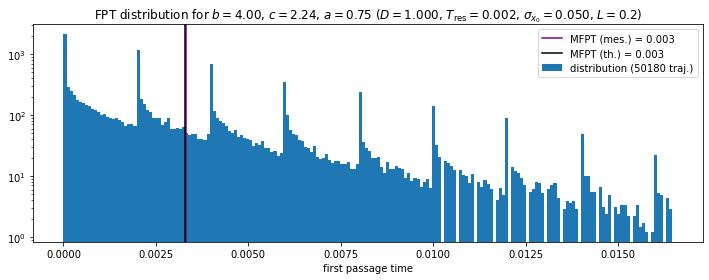

In [122]:
do_fpt_distrib(True)

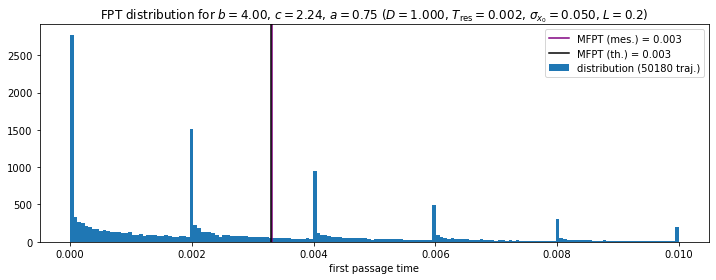

In [123]:
fpt_max = 0.01
do_fpt_distrib(False, bins=168)
plt.savefig("blah.pdf", bbox_inches='tight')

---

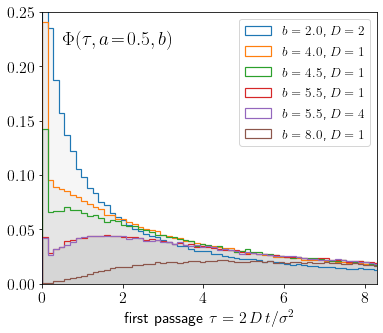

In [2]:
plt.figure(figsize=(6,5))
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16
})

fpt_max = 0.005
ftau_max = 8.3
normalized = True
ft_max = ftau_max if normalized else fpt_max
bins = 60
ylog = True

#for i in [302, 305, 300, 303, 301, 304]:
for i in [312, 302, 305, 303, 311, 304]:
    itempath = "data-2d-fpt-x0var/"+str(i)
    
    ppath = itempath+"-params.csv"
    df = pd.read_csv(ppath, sep=',', header=None)
    params = dict(df.set_index(0).T.squeeze())
    σ = params['x0sigma_x']
    D = params['D']
    b = params['L']/σ
    a = params['a']
    
    first_times = np.loadtxt(itempath+"-ft.csv")
    n_traj = len(first_times)
    
    if normalized:
        first_times = 2*D*first_times/σ**2
    
    plt.hist(first_times, bins=bins, range=(0,ft_max*1.01), weights=bins/ft_max*np.ones(n_traj)/n_traj,
             histtype='stepfilled', alpha=0.07, color='gray')
    plt.hist(first_times, bins=bins, range=(0,ft_max*1.01), weights=bins/ft_max*np.ones(n_traj)/n_traj,
             label=r"$b={:.1f}$, $D={:.0f}$".format(b,D), histtype='step', lw=1.2)

if normalized:
    plt.xlim(0, ftau_max)
    plt.ylim(0, 0.25)
    plt.xlabel(r"first passage $\tau = 2\,D\,t/\sigma^2$")
    plt.text(0.5,0.22,r"$\Phi(\tau,a\!=\!0.5,b)$",fontsize='large')
else:
    plt.xlim(0, fpt_max)
    if ylog:
        plt.yscale('log')
        plt.ylim(2e1, None)
    else:
        plt.ylim(0, 200)

plt.legend(fontsize='small')
plt.savefig("fpt-distrib-2d-adim.pdf", bbox_inches='tight')